In [1]:
!pip install tensorflow

In [2]:
# 安装 Kaggle 库
!pip install -q kaggle

# 创建 .kaggle 文件夹
!mkdir -p ~/.kaggle

# 假设你的 kaggle.json 文件在当前目录中，将其复制到 .kaggle 文件夹
!cp kaggle.json ~/.kaggle/

# 设置权限
!chmod 600 ~/.kaggle/kaggle.json

# 下载数据集
!kaggle datasets download -d yuzhouzhu/attosecond-streaking-phase-retrieval-data-8w

# 解压数据集
!unzip attosecond-streaking-phase-retrieval-data-8w.zip -d data/

import pandas as pd

# 加载训练数据
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

# 查看数据
print("finish")


Dataset URL: https://www.kaggle.com/datasets/yuzhouzhu/attosecond-streaking-phase-retrieval-data-8w
License(s): MIT
100% 6.03G/6.04G [00:40<00:00, 152MB/s]
100% 6.04G/6.04G [00:40<00:00, 160MB/s]
Archive:  attosecond-streaking-phase-retrieval-data-8w.zip
  inflating: data/X_train.csv        
  inflating: data/y_train.csv        
finish


In [ ]:

import pandas as pd

# 加载训练数据
X_train = pd.read_csv('/content/data/X_train.csv')
y_train = pd.read_csv('/content/data/y_train.csv')

# 查看数据
print("finish\n")

import numpy as np
import matplotlib.pyplot as plt

# 划分测试集，假设取最后 500 条数据
num_test_samples = 500  # 固定测试集大小

X_test = X_train[-num_test_samples:]  # 测试集输入
y_test = y_train[-num_test_samples:]  # 测试集输出

finish



After reshape: X_train_np.shape = (79999, 301, 58)
y_train_np.shape = (79999, 290)


随机选到的连续段起始索引: [32953, 61348, 69352, 72512]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


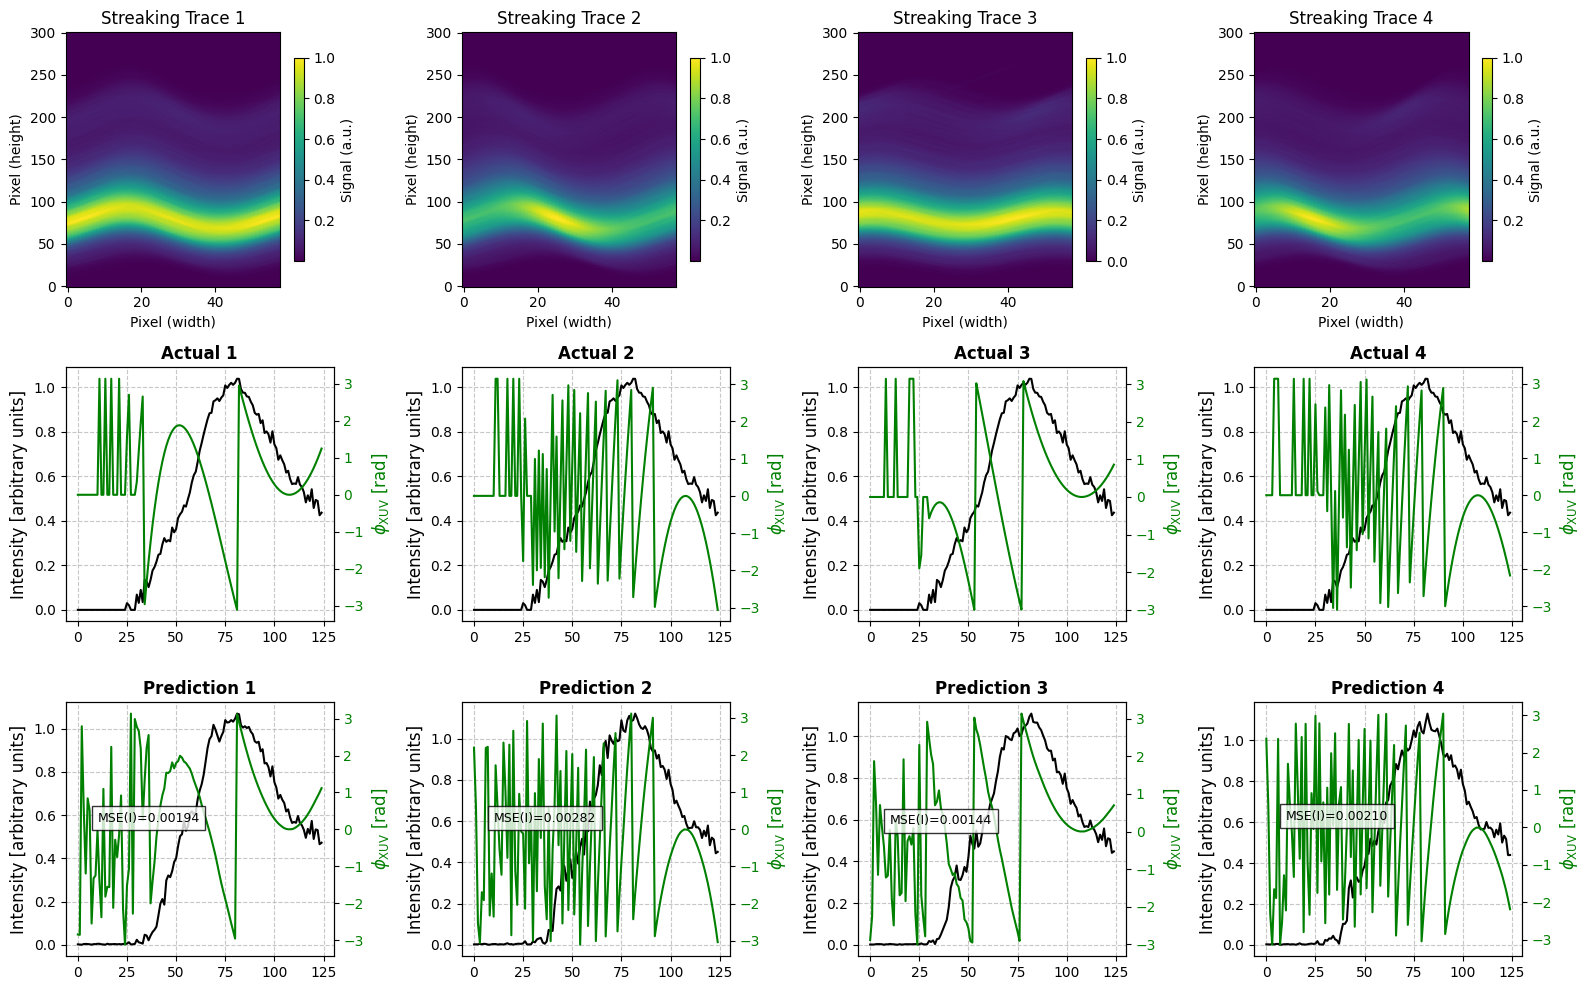

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import layers, losses



# 假设每个条纹图大小为 (301, 58)
img_height, img_width = 301, 58

# 转成 NumPy 并 reshape 为 (N, 301, 58)
X_train_np = X_train.values.astype(np.float32).reshape((-1, img_height, img_width))
y_train_np = y_train.values.astype(np.float32)

num_samples = X_train_np.shape[0]
print("After reshape: X_train_np.shape =", X_train_np.shape)
print("y_train_np.shape =", y_train_np.shape)

########################
# 2) 加载你的已训练模型
########################
class Patches(layers.Layer):
    def call(self, images):
        return tf.reshape(images, (tf.shape(images)[0], 301, 58))

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.projection = layers.Dense(embed_dim)
        self.pos_emb = self.add_weight(
            name="pos_emb",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal",
            trainable=True
        )
    def call(self, patch):
        x = self.projection(patch)
        x = x + self.pos_emb
        return x

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

custom_objects = {
    "Patches": Patches,
    "PatchEncoder": PatchEncoder,
    "TransformerBlock": TransformerBlock,
    "mse": losses.MeanSquaredError()
}

model_path = '/content/attosecond_model_8w.h5'  # 你的模型路径
model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

########################
# 3) 随机抽取 4 个连续片段，各 500 条
########################
segment_len = 500
num_sets = 4
max_start = num_samples - segment_len

# ⚠ 不再设置 random.seed(42)，以保证每次运行随机结果都不同
# random.seed(42)  # 移除这一行

start_indices = []
while len(start_indices) < num_sets:
    start_idx = random.randint(0, max_start)
    # 为避免重叠，相距 < segment_len 即冲突
    conflict = any(abs(s - start_idx) < segment_len for s in start_indices)
    if not conflict:
        start_indices.append(start_idx)

start_indices.sort()
print("随机选到的连续段起始索引:", start_indices)

test_sets = []
for st in start_indices:
    X_test_part = X_train_np[st : st + segment_len]
    y_test_part = y_train_np[st : st + segment_len]
    test_sets.append((X_test_part, y_test_part))

########################
# 4) 可视化
########################
split_xuv = 125  # XUV 实部/虚部各125（示例）

plt.figure(figsize=(16, 10))

for i, (X_test_part, Y_test_part) in enumerate(test_sets):
    x_sample = X_test_part[0]
    y_true = Y_test_part[0]

    # 若模型需要 4D 输入
    X_input_4D = x_sample.reshape(1, 301, 58, 1)
    y_pred = model.predict(X_input_4D)[0]

    # -- 第一行：imshow(X_train)
    plt.subplot(3, 4, i+1)
    plt.title(f"Streaking Trace {i+1}", fontsize=12)
    plt.imshow(x_sample, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Signal (a.u.)', shrink=0.8)
    plt.xlabel("Pixel (width)")
    plt.ylabel("Pixel (height)")

    # 拆分 y_true
    y_true_real = y_true[:split_xuv]
    y_true_imag = y_true[split_xuv: 2*split_xuv]
    true_intensity = np.sqrt(y_true_real**2 + y_true_imag**2)
    true_phase = np.arctan2(y_true_imag, y_true_real)

    # 第二行：Actual
    plt.subplot(3, 4, 4 + i+1)
    plt.title(f"Actual {i+1}", fontsize=12, fontweight='bold')
    plt.plot(true_intensity, color='black', linewidth=1.5)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylabel("Intensity [arbitrary units]", fontsize=12, color='black')
    plt.tick_params(axis='y', labelcolor='black')

    ax2 = plt.gca().twinx()
    ax2.plot(true_phase, color='green', linewidth=1.5)
    ax2.set_ylabel(r'$\phi_{\mathrm{XUV}}$ [rad]', fontsize=12, color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # 拆分 y_pred
    y_pred_real = y_pred[:split_xuv]
    y_pred_imag = y_pred[split_xuv: 2*split_xuv]
    pred_intensity = np.sqrt(y_pred_real**2 + y_pred_imag**2)
    pred_phase = np.arctan2(y_pred_imag, y_pred_real)

    # 第三行：Prediction
    plt.subplot(3, 4, 8 + i+1)
    plt.title(f"Prediction {i+1}", fontsize=12, fontweight='bold')
    plt.plot(pred_intensity, color='black', linewidth=1.5)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylabel("Intensity [arbitrary units]", fontsize=12, color='black')
    plt.tick_params(axis='y', labelcolor='black')

    ax3 = plt.gca().twinx()
    ax3.plot(pred_phase, color='green', linewidth=1.5)
    ax3.set_ylabel(r'$\phi_{\mathrm{XUV}}$ [rad]', fontsize=12, color='green')
    ax3.tick_params(axis='y', labelcolor='green')

    # 只显示「强度」的 MSE
    mse_intensity = np.mean((pred_intensity - true_intensity)**2)
    plt.text(
        10, 0.2,
        f"MSE(I)={mse_intensity:.5f}",
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.8)
    )

plt.tight_layout()
plt.show()
